# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Загрузка изображения
input_image_path = "sar_2.jpg"
original_gray = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

if original_gray is None:
    raise FileNotFoundError(f"Изображение '{input_image_path}' не найдено")

print(f"Оригинальное изображение: {original_gray.shape}")
print(f"Тип данных: {original_gray.dtype}")
print(f"Диапазон значений: {original_gray.min()} - {original_gray.max()}")


Оригинальное изображение: (1199, 1200)
Тип данных: uint8
Диапазон значений: 0 - 255


После обрезки до чётных размеров: (1198, 1200)
Новые размеры: 1198x1200
Исходное изображение сохранено в 'original_image.txt'


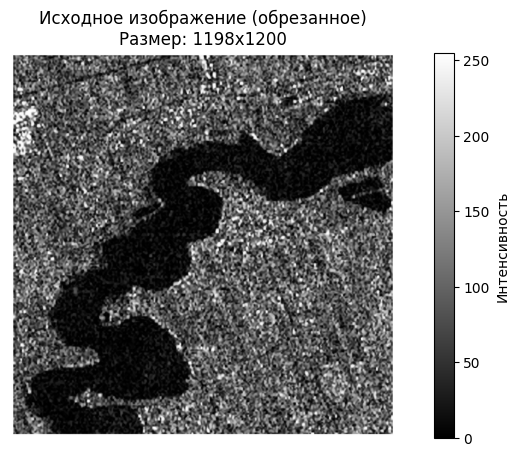

In [2]:
processed_image = original_gray.astype(np.float32)

# Обрезка до чётных размеров (требование для вейвлет-преобразования)
height, width = processed_image.shape
new_height = height - height % 2
new_width = width - width % 2
processed_image = processed_image[:new_height, :new_width]

print(f"После обрезки до чётных размеров: {processed_image.shape}")
print(f"Новые размеры: {new_height}x{new_width}")

np.savetxt('original_image.txt', processed_image, fmt='%.0f')
print("Исходное изображение сохранено в 'original_image.txt'")

plt.figure(figsize=(10, 5))
plt.imshow(processed_image, cmap='gray')
plt.title(f'Исходное изображение (обрезанное)\nРазмер: {new_height}x{new_width}')
plt.colorbar(label='Интенсивность')
plt.axis('off')
plt.show()

In [3]:
def apply_haar_transform(image_matrix):
    """
    Применяет двумерное вейвлет-преобразование Хаара к изображению

    Параметры:
    image_matrix -- входное изображение (float32)

    Возвращает:
    LL, LH, HL, HH -- субполосы вейвлет-коэффициентов
    """
    rows, cols = image_matrix.shape
    half_rows, half_cols = rows // 2, cols // 2

    row_transformed = np.zeros_like(image_matrix, dtype=np.float32)

    for i in range(rows):
        current_row = image_matrix[i, :]
        row_averages = (current_row[0::2] + current_row[1::2]) * 0.5
        row_differences = (current_row[0::2] - current_row[1::2]) * 0.5

        row_transformed[i, :half_cols] = row_averages
        row_transformed[i, half_cols:] = row_differences

    # Второй этап: преобразование по столбцам
    column_transformed = np.zeros_like(row_transformed, dtype=np.float32)

    for j in range(cols):
        current_column = row_transformed[:, j]
        col_averages = (current_column[0::2] + current_column[1::2]) * 0.5
        col_differences = (current_column[0::2] - current_column[1::2]) * 0.5

        column_transformed[:half_rows, j] = col_averages
        column_transformed[half_rows:, j] = col_differences

    LL_band = column_transformed[:half_rows, :half_cols]      # Низкие частоты
    LH_band = column_transformed[:half_rows, half_cols:]      # Горизонтальные детали
    HL_band = column_transformed[half_rows:, :half_cols]      # Вертикальные детали
    HH_band = column_transformed[half_rows:, half_cols:]      # Диагональные детали

    return LL_band, LH_band, HL_band, HH_band, column_transformed

print("Функция вейвлет-преобразования определена")

Функция вейвлет-преобразования определена


In [4]:
LL_coeff, LH_coeff, HL_coeff, HH_coeff, full_transform = apply_haar_transform(processed_image)

print("Вейвлет-преобразование выполнено успешно")
print(f"Размеры субполос: {LL_coeff.shape} (LL), {LH_coeff.shape} (LH), "
      f"{HL_coeff.shape} (HL), {HH_coeff.shape} (HH)")

Вейвлет-преобразование выполнено успешно
Размеры субполос: (599, 600) (LL), (599, 600) (LH), (599, 600) (HL), (599, 600) (HH)


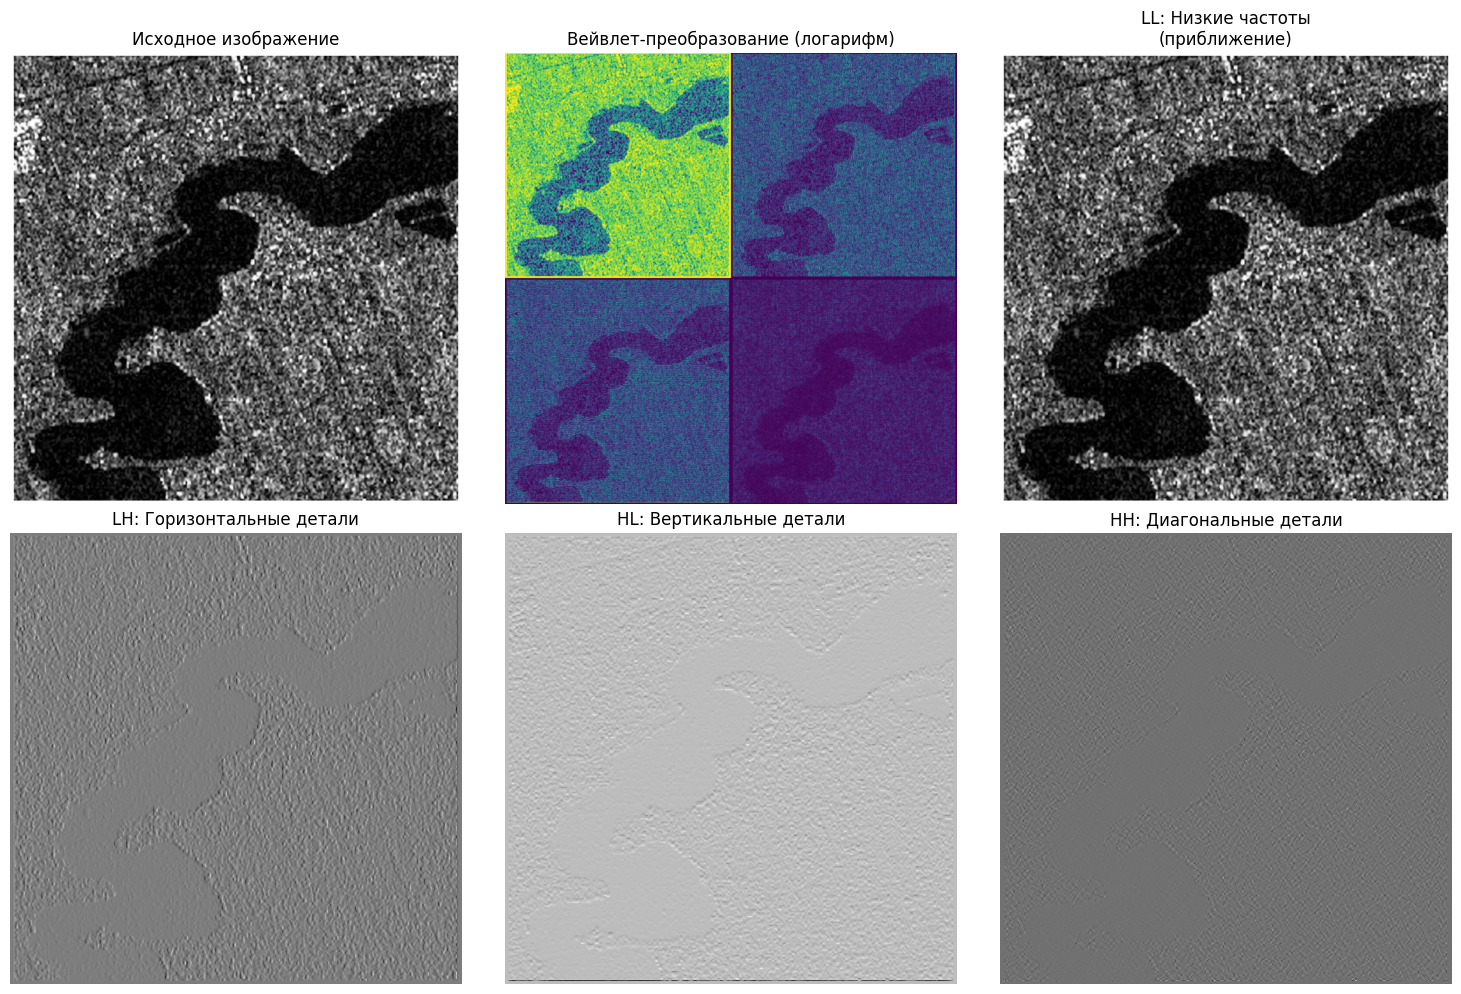

ДИАПАЗОНЫ КОЭФФИЦИЕНТОВ:
LL (приближение): [0.00, 255.00]
LH (горизонтальные): [-53.75, 55.50]
HL (вертикальные): [-111.50, 39.50]
HH (диагональные): [-12.50, 15.75]


In [5]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(processed_image, cmap='gray')
axes[0, 0].set_title('Исходное изображение')
axes[0, 0].axis('off')

transform_display = np.log(np.abs(full_transform) + 1)
axes[0, 1].imshow(transform_display, cmap='viridis')
axes[0, 1].set_title('Вейвлет-преобразование (логарифм)')
axes[0, 1].axis('off')

axes[0, 2].imshow(LL_coeff, cmap='gray')
axes[0, 2].set_title('LL: Низкие частоты\n(приближение)')
axes[0, 2].axis('off')

axes[1, 0].imshow(LH_coeff, cmap='gray')
axes[1, 0].set_title('LH: Горизонтальные детали')
axes[1, 0].axis('off')

axes[1, 1].imshow(HL_coeff, cmap='gray')
axes[1, 1].set_title('HL: Вертикальные детали')
axes[1, 1].axis('off')

axes[1, 2].imshow(HH_coeff, cmap='gray')
axes[1, 2].set_title('HH: Диагональные детали')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("ДИАПАЗОНЫ КОЭФФИЦИЕНТОВ:")
print(f"LL (приближение): [{LL_coeff.min():.2f}, {LL_coeff.max():.2f}]")
print(f"LH (горизонтальные): [{LH_coeff.min():.2f}, {LH_coeff.max():.2f}]")
print(f"HL (вертикальные): [{HL_coeff.min():.2f}, {HL_coeff.max():.2f}]")
print(f"HH (диагональные): [{HH_coeff.min():.2f}, {HH_coeff.max():.2f}]")

Квантование выполнено успешно
Уровни квантования: 4
LH: минимум=-53.750, шаг=36.417
HL: минимум=-111.500, шаг=50.333
HH: минимум=-12.500, шаг=9.417


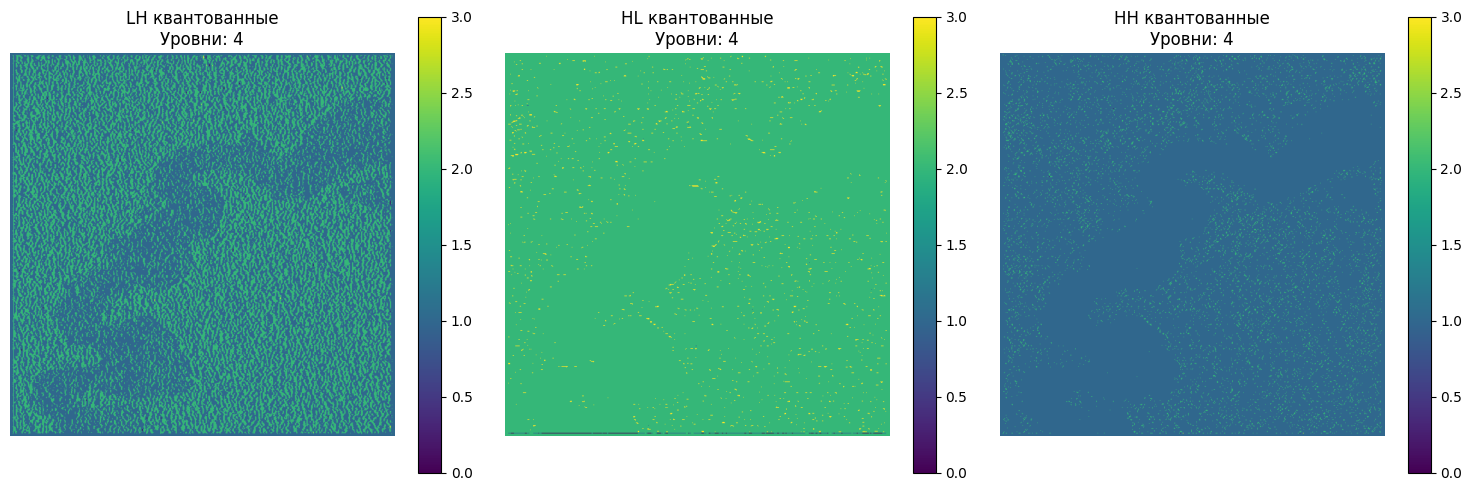

In [6]:
def apply_quantization(input_data, quantization_levels=4):
    """
    Применяет равномерное квантование к данным

    Параметры:
    input_data -- входные данные для квантования
    quantization_levels -- количество уровней квантования

    Возвращает:
    quantized_values -- квантованные значения
    min_value -- минимальное значение исходных данных
    step_size -- шаг квантования
    """
    data_min = np.min(input_data)
    data_max = np.max(input_data)

    if data_max == data_min:
        return np.zeros_like(input_data, dtype=int), data_min, 1.0

    quantization_step = (data_max - data_min) / (quantization_levels - 1)

    quantized = np.round((input_data - data_min) / quantization_step).astype(int)
    quantized = np.clip(quantized, 0, quantization_levels - 1)

    return quantized, data_min, quantization_step

quantization_levels = 4
LH_quantized, LH_min, LH_step = apply_quantization(LH_coeff, quantization_levels)
HL_quantized, HL_min, HL_step = apply_quantization(HL_coeff, quantization_levels)
HH_quantized, HH_min, HH_step = apply_quantization(HH_coeff, quantization_levels)

print("Квантование выполнено успешно")
print(f"Уровни квантования: {quantization_levels}")
print(f"LH: минимум={LH_min:.3f}, шаг={LH_step:.3f}")
print(f"HL: минимум={HL_min:.3f}, шаг={HL_step:.3f}")
print(f"HH: минимум={HH_min:.3f}, шаг={HH_step:.3f}")

# Визуализация квантованных данных
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im1 = axes[0].imshow(LH_quantized, cmap='viridis')
axes[0].set_title(f'LH квантованные\nУровни: {quantization_levels}')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(HL_quantized, cmap='viridis')
axes[1].set_title(f'HL квантованные\nУровни: {quantization_levels}')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(HH_quantized, cmap='viridis')
axes[2].set_title(f'HH квантованные\nУровни: {quantization_levels}')
axes[2].axis('off')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

In [7]:
def perform_rle_encoding(input_array):
    """
    Выполняет кодирование длин серий (Run-Length Encoding)

    Параметры:
    input_array -- входной массив для кодирования

    Возвращает:
    encoded_list -- список кортежей (значение, количество повторений)
    """
    flattened = input_array.flatten()
    encoded_sequence = []

    previous_value = flattened[0]
    repetition_count = 1

    for current_value in flattened[1:]:
        if current_value == previous_value:
            repetition_count += 1
        else:
            encoded_sequence.append((previous_value, repetition_count))
            previous_value = current_value
            repetition_count = 1

    encoded_sequence.append((previous_value, repetition_count))
    return encoded_sequence

LH_rle_encoded = perform_rle_encoding(LH_quantized)
HL_rle_encoded = perform_rle_encoding(HL_quantized)
HH_rle_encoded = perform_rle_encoding(HH_quantized)

print("Кодирование длин серий выполнено")
print(f"LH: {len(LH_rle_encoded)} серий (было {LH_quantized.size} элементов)")
print(f"HL: {len(HL_rle_encoded)} серий (было {HL_quantized.size} элементов)")
print(f"HH: {len(HH_rle_encoded)} серий (было {HH_quantized.size} элементов)")

Кодирование длин серий выполнено
LH: 100539 серий (было 359400 элементов)
HL: 3683 серий (было 359400 элементов)
HH: 20995 серий (было 359400 элементов)


In [8]:
output_filename = 'wavelet_data.txt'

with open(output_filename, 'w') as output_file:
    np.savetxt(output_file, LL_coeff, fmt='%.2f')

    for value, count in LH_rle_encoded:
        output_file.write(f"{value} {count}\n")

    for value, count in HL_rle_encoded:
        output_file.write(f"{value} {count}\n")

    for value, count in HH_rle_encoded:
        output_file.write(f"{value} {count}\n")

print(f"Сжатые данные сохранены в '{output_filename}'")

Сжатые данные сохранены в 'wavelet_data.txt'


АНАЛИЗ ЭФФЕКТИВНОСТИ СЖАТИЯ
1. Размер исходного изображения: 5,750,400 байт
2. Размер после сжатия: 2,736,342 байт
3. Экономия памяти: 3,014,058 байт
4. Коэффициент сжатия: 0.476 (47.6%)
5. Снижение объёма данных: 52.41%

ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:
Размер LL субполосы: 1,437,600 байт
Размер LH после RLE: примерно 1,812,984 символов
Размер HL после RLE: примерно 68,804 символов
Размер HH после RLE: примерно 385,706 символов


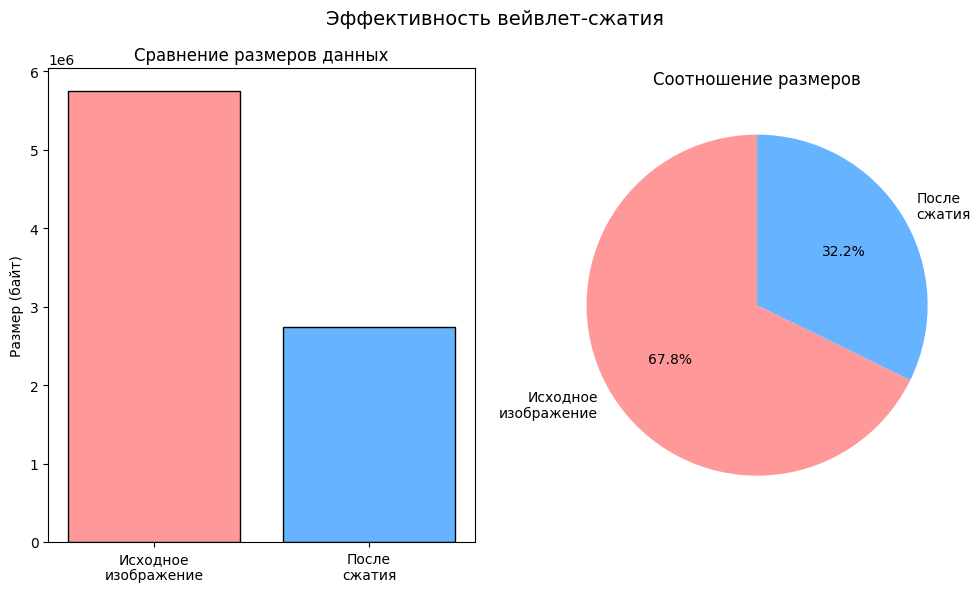

In [9]:
original_data_size = processed_image.nbytes

with open(output_filename, 'r') as compressed_file:
    compressed_data_content = compressed_file.read()
    compressed_data_size = len(compressed_data_content.encode('utf-8'))

size_reduction = original_data_size - compressed_data_size
compression_ratio = compressed_data_size / original_data_size
reduction_percentage = (size_reduction / original_data_size) * 100

print("=" * 60)
print("АНАЛИЗ ЭФФЕКТИВНОСТИ СЖАТИЯ")
print("=" * 60)
print(f"1. Размер исходного изображения: {original_data_size:,} байт")
print(f"2. Размер после сжатия: {compressed_data_size:,} байт")
print(f"3. Экономия памяти: {size_reduction:,} байт")
print(f"4. Коэффициент сжатия: {compression_ratio:.3f} ({compressed_data_size/original_data_size*100:.1f}%)")
print(f"5. Снижение объёма данных: {reduction_percentage:.2f}%")
print("=" * 60)

print("\nДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:")
print(f"Размер LL субполосы: {LL_coeff.nbytes:,} байт")
print(f"Размер LH после RLE: примерно {len(str(LH_rle_encoded)):,} символов")
print(f"Размер HL после RLE: примерно {len(str(HL_rle_encoded)):,} символов")
print(f"Размер HH после RLE: примерно {len(str(HH_rle_encoded)):,} символов")

labels = ['Исходное\nизображение', 'После\nсжатия']
sizes = [original_data_size, compressed_data_size]
colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(labels, sizes, color=colors, edgecolor='black')
plt.ylabel('Размер (байт)')
plt.title('Сравнение размеров данных')

plt.subplot(1, 2, 2)
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Соотношение размеров')

plt.suptitle('Эффективность вейвлет-сжатия', fontsize=14)
plt.tight_layout()
plt.show()

In [10]:
def reconstruct_from_rle(rle_data, original_shape):
    """
    Восстанавливает массив из RLE-кодированных данных
    """
    total_elements = original_shape[0] * original_shape[1]
    reconstructed = []

    for value, count in rle_data:
        reconstructed.extend([value] * count)

    reconstructed = np.array(reconstructed[:total_elements])
    return reconstructed.reshape(original_shape)

LH_reconstructed = reconstruct_from_rle(LH_rle_encoded, LH_quantized.shape)
HL_reconstructed = reconstruct_from_rle(HL_rle_encoded, HL_quantized.shape)
HH_reconstructed = reconstruct_from_rle(HH_rle_encoded, HH_quantized.shape)

lh_correct = np.array_equal(LH_quantized, LH_reconstructed)
hl_correct = np.array_equal(HL_quantized, HL_reconstructed)
hh_correct = np.array_equal(HH_quantized, HH_reconstructed)

print("=" * 60)
print("ПРОВЕРКА КОРРЕКТНОСТИ ВОССТАНОВЛЕНИЯ ДАННЫХ")
print("=" * 60)
print(f"LH восстановлены корректно: {'✓' if lh_correct else '✗'}")
print(f"HL восстановлены корректно: {'✓' if hl_correct else '✗'}")
print(f"HH восстановлены корректно: {'✓' if hh_correct else '✗'}")
print("=" * 60)

if lh_correct and hl_correct and hh_correct:
    print("ВСЕ ДАННЫЕ ВОССТАНОВЛЕНЫ КОРРЕКТНО!")
else:
    print("Обнаружены ошибки при восстановлении данных")

ПРОВЕРКА КОРРЕКТНОСТИ ВОССТАНОВЛЕНИЯ ДАННЫХ
LH восстановлены корректно: ✓
HL восстановлены корректно: ✓
HH восстановлены корректно: ✓
ВСЕ ДАННЫЕ ВОССТАНОВЛЕНЫ КОРРЕКТНО!


In [11]:
print("=" * 70)
print("ИТОГОВЫЙ ОТЧЁТ ПО ВЕЙВЛЕТ-СЖАТИЮ ИЗОБРАЖЕНИЯ")
print("=" * 70)
print(f"Исходное изображение: {original_gray.shape} → {processed_image.shape}")
print(f"Метод сжатия: Вейвлет-преобразование Хаара + RLE")
print(f"Уровни квантования: {quantization_levels}")
print(f"\nРазмеры субполос:")
print(f"  LL (сохраняется полностью): {LL_coeff.shape}")
print(f"  LH (кодируется RLE): {LH_coeff.shape}")
print(f"  HL (кодируется RLE): {HL_coeff.shape}")
print(f"  HH (кодируется RLE): {HH_coeff.shape}")
print(f"\nЭффективность сжатия:")
print(f"  Исходный размер: {original_data_size:,} байт")
print(f"  Сжатый размер: {compressed_data_size:,} байт")
print(f"  Экономия: {size_reduction:,} байт ({reduction_percentage:.1f}%)")
print(f"  Коэффициент сжатия: {compression_ratio:.3f}")
print("=" * 70)

ИТОГОВЫЙ ОТЧЁТ ПО ВЕЙВЛЕТ-СЖАТИЮ ИЗОБРАЖЕНИЯ
Исходное изображение: (1199, 1200) → (1198, 1200)
Метод сжатия: Вейвлет-преобразование Хаара + RLE
Уровни квантования: 4

Размеры субполос:
  LL (сохраняется полностью): (599, 600)
  LH (кодируется RLE): (599, 600)
  HL (кодируется RLE): (599, 600)
  HH (кодируется RLE): (599, 600)

Эффективность сжатия:
  Исходный размер: 5,750,400 байт
  Сжатый размер: 2,736,342 байт
  Экономия: 3,014,058 байт (52.4%)
  Коэффициент сжатия: 0.476
